In [22]:
# 0. Import all libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [23]:
# 1. Import data
# Close prices + Other prices + Volumes
file_path = './data/SMCI_merged.csv'
data = pd.read_csv(file_path)

In [24]:
# 2. Preparing Data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.sort_index(ascending=True)

columns_to_keep = ['Open', 'High', 'Low', 'Close/Last', 'Volume', 'DPRIME', 'VIX_Close']
data = data[columns_to_keep]

# Subset data for the specified date range
start_date = '2014-06-24'
end_date = '2024-06-21'
data = data[(data.index >= start_date) & (data.index <= end_date)]

In [25]:
# Split data, method 2
# train_set = data[(data.index >= '2014-06-24') & (data.index < '2024-06-19')].copy()
# valid_set = data[(data.index >= '2024-06-20') & (data.index <= '2024-06-21')].copy()

train_set = data[(data.index >= '2014-06-24') & (data.index < '2023-06-24')].copy()
valid_set = data[(data.index >= '2022-06-25') & (data.index <= '2024-06-21')].copy()

In [26]:
# 2. Setup Variables
# 2.1 Time horizon set to be 9 years for training, 1 year for validation
# 2.2 time steps for LSTM
time_steps = 60     # tested [30, 60, 90, 120], 90 is the most efficient one

# 2.3 Feature selection
selected_features = ['Close/Last', 'Volume', 'DPRIME', 'VIX_Close']

num_features = len(selected_features)

In [27]:
def train_and_evaluate_lstm():
    # 3. Data pre-processing
    scalers = {}
    train_data = train_set.copy()
    valid_data = valid_set.copy()

    for feature in selected_features:
        scalers[feature] = MinMaxScaler(feature_range=(0, 1))
        train_data[feature] = scalers[feature].fit_transform(train_set[feature].values.reshape(-1, 1))
        valid_data[feature] = scalers[feature].transform(valid_set[feature].values.reshape(-1, 1))

    # Initialize lists to store training and validation data
    x_train, y_train = [], []
    for i in range(time_steps, len(train_data)):
        x_train.append(train_data[selected_features].values[i-time_steps:i])
        y_train.append(train_data['Close/Last'].values[i])

    x_valid, y_valid = [], []
    for i in range(time_steps, len(valid_data)):
        x_valid.append(valid_data[selected_features].values[i-time_steps:i])
        y_valid.append(valid_data['Close/Last'].values[i])

    # Convert lists to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_valid, y_valid = np.array(x_valid), np.array(y_valid)

    # 4. Build Model - function
    def build_model():
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, len(selected_features))))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    # Build and train model
    model = build_model()
    history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)

    # Make Prediction
    predicted_y_valid_normalized = model.predict(x_valid)
    predicted_y_valid = scalers['Close/Last'].inverse_transform(predicted_y_valid_normalized)

    # Calculate RMSE
    valid_rmse = np.sqrt(mean_squared_error(valid_set['Close/Last'].values[time_steps:], predicted_y_valid))
    print(f"LSTM RMSE on validation set: {valid_rmse}")


    # Visualization of results
    plt.figure(figsize=(14, 7))
    plt.plot(train_set.index, train_set['Close/Last'], label='Training Data')
    plt.plot(valid_set.index[time_steps:], valid_set['Close/Last'].values[time_steps:], label='Validation Data')
    plt.plot(valid_set.index[time_steps:], predicted_y_valid, label='Validation Predictions')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Stock Price Prediction with LSTM (SMCI)')
    plt.legend()
    plt.show()

Epoch 1/25


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0011 - val_loss: 0.0116
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9278e-04 - val_loss: 0.0098
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6044e-04 - val_loss: 0.0071
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.3046e-04 - val_loss: 0.0059
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0810e-04 - val_loss: 0.0035
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0578e-04 - val_loss: 0.0024
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.1042e-04 - val_loss: 0.0035
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.8887e-05 - val_loss: 0.0022
Epoch 9/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.2732e-05 - val_loss: 0.0025
Epoch 10/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.4310e-05 - val_loss: 0.0020
Epoch 11/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.8218e-05 - val_loss: 0.0020
Epoch 12/25
63/63 ━━━━━━━━━━━━━━━━

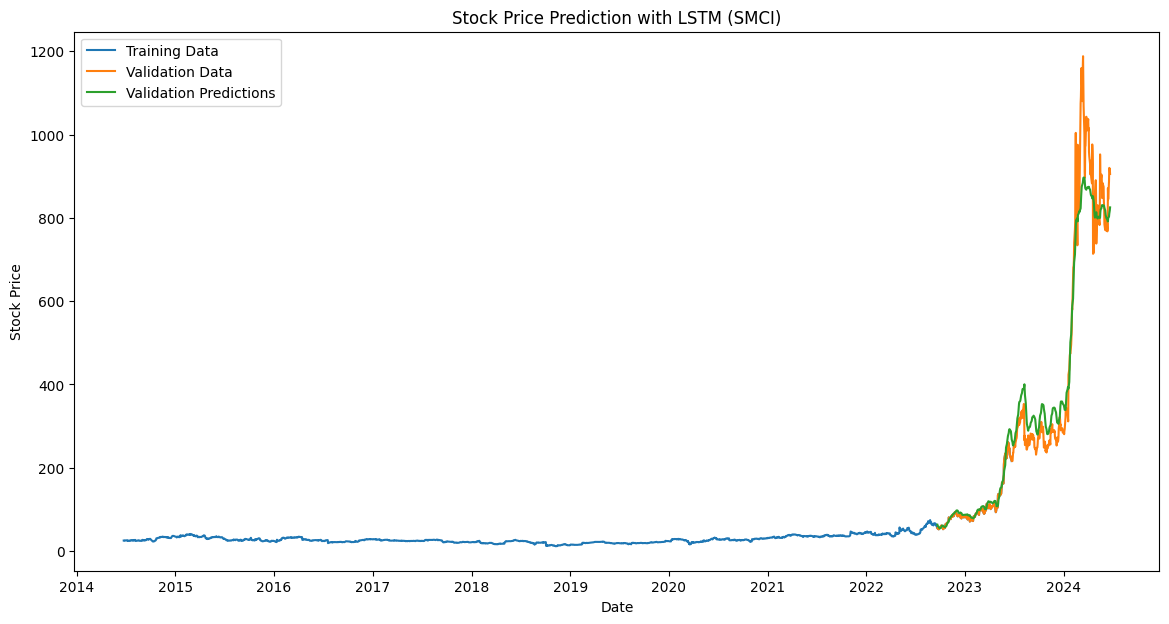

In [28]:
train_and_evaluate_lstm()

In [57]:
from keras.layers import Input


def train_and_predict_1_day():
    # 3. Data pre-processing
    scalers = {}
    data_copy = data.copy()

    for feature in selected_features:
        scalers[feature] = MinMaxScaler(feature_range=(0, 1))
        data_copy[feature] = scalers[feature].fit_transform(data[feature].values.reshape(-1, 1))

    # Initialize lists to store training data
    x, y = [], []
    for i in range(time_steps, len(data_copy)):
        x.append(data_copy[selected_features].values[i-time_steps:i])
        y.append(data_copy['Close/Last'].values[i])

    # Convert lists to numpy arrays
    x, y = np.array(x), np.array(y)

    # 4. Build Model - function
    def build_model():
        model = Sequential()
        model.add(Input(shape=(time_steps, len(selected_features)))) # to avoid warning
        model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, len(selected_features))))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    # Build and train model
    model = build_model()
    model.fit(x, y, epochs=25, batch_size=32, verbose=0)

    # Prepare data for prediction
    last_sequence = data_copy[selected_features].values[-time_steps:]

    # Make prediction for the next day
    next_day_prediction_normalized = model.predict(last_sequence.reshape(1, time_steps, len(selected_features)))
    next_day_prediction = scalers['Close/Last'].inverse_transform(next_day_prediction_normalized)

    return next_day_prediction[0][0]


In [58]:
# Container to hold predictions
predictions = []

# Perform 10 iterations
for _ in range(10):
    prediction = train_and_predict_1_day()
    predictions.append(prediction)

/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [59]:
predictions

[808.10394,
 876.0902,
 954.64136,
 850.1565,
 872.9705,
 865.06683,
 942.3378,
 861.4106,
 832.50415,
 838.0224]

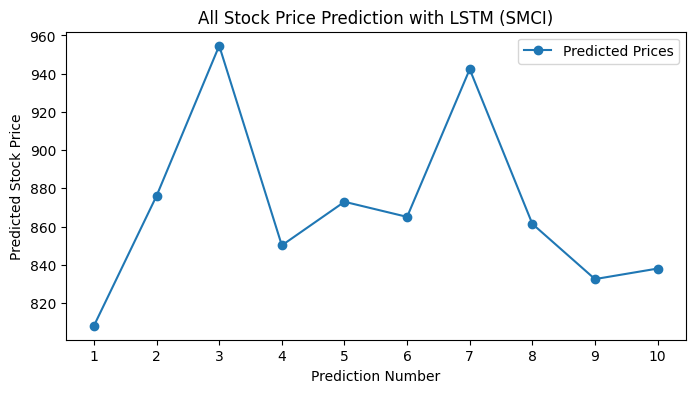

In [60]:
# Plot predicted prices
# Visualization of results
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(predictions) + 1), predictions, marker='o', label='Predicted Prices')

plt.xticks(ticks=range(1, len(predictions) + 1))
plt.xlabel('Prediction Number')
plt.ylabel('Predicted Stock Price')
plt.title('All Stock Price Prediction with LSTM (SMCI)')
plt.legend()
plt.show()

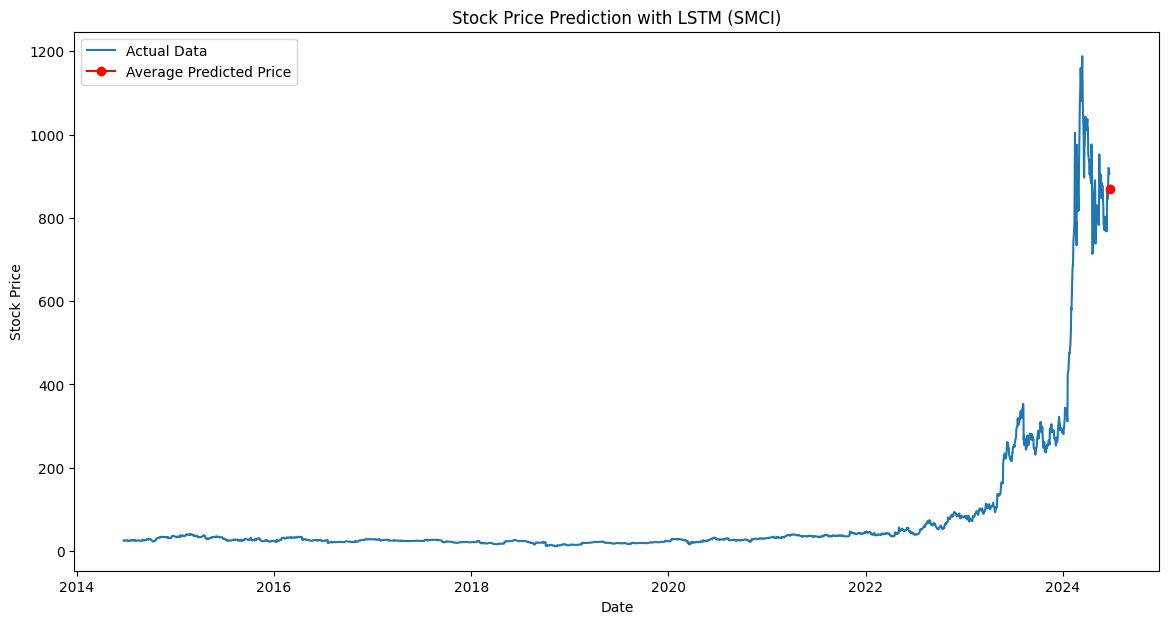

In [61]:
# Calculate average prediction
prediction_avg = np.mean(predictions)

# Get the last date for plotting
last_date = data.index[-1]

# Generate the next working day for prediction
next_working_day = last_date + pd.tseries.offsets.BDay(1)

# Visualization of results
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close/Last'], label='Actual Data')

# Plot average prediction
plt.plot(next_working_day, prediction_avg, marker='o', color='r', label='Average Predicted Price')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM (SMCI)')
plt.legend()
plt.show()